Se aborda en esta primera parte del proyecto final *el problema de la determinación del redshift*.

Se muestra el mejor código pensado para resolver este problema y que en cuya arquitectura sean puestos en práctica los diferentes temas abordados a lo largo del curso.

Se dividirá el código en bloques con una tarea diferente, indicando su función y sus implicaciones.

Elaborado por: Oscar Raúl Sánchez Padilla

In [2]:
# BLOQUE 1: IMPORTACIONES Y CONFIGURACIÓN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn: Servirá para separar los datos en train y test, hará la validación cruzada más delante, Normalizará y/o escalará los datos y calculará métricas.

#Usaremos la siguiente librería para la cross-validation
from sklearn.model_selection import train_test_split, KFold  

#StandardScaler estandarizará las características de tus datos. Evitará darles pesos diferentes a datos de diferentes tamaños o magnitudes.
#RobustScaler nos funcionara como alternativa a StandardScaler que maneja mejor outliers(valores atipicos o fuera de lo normal)
from sklearn.preprocessing import StandardScaler, RobustScaler

#Las siguientes funciones servirán para evaluar qué tan bueno será nuestro modelo de regresión comparando las predicciones con los valores reales. Son métricas de rendimiento.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# TensorFlow y Keras
import tensorflow as tf

# Las componentes principales para construir y entrenar redes neuronales:
from tensorflow.keras import layers, models, callbacks, regularizers

# Usamos el siguiente algoritmo de optimización para entrenamiento de las redes neuronales:
from tensorflow.keras.optimizers import Adam

# Para reproducibilidad fijamos los numeros "aleatorios" para que siempre sean iguales.
# Esto es útil para saber si los cambios son por mi código y no por azar. 
np.random.seed(42)
tf.random.set_seed(42) #Usamos el número 42 como convención dentro del mundo de la programación, en general puede ser cualquier numero

# Esto hará que nuestras gráficas se vean más presentables (No afecta al código en si mismo)
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
# BLOQUE 2: CARGA Y PREPROCESAMIENTO DE DATOS

# Rutas de tus archivos (guardados localmente)
csv_path = r'C:\Users\op354\OneDrive\Documentos\Oscar\UG\Repositorio Github\ejerciosytareas-Oscarraul28\balanced_spectra_features.csv'
npz_path = r'C:\Users\op354\OneDrive\Documentos\Oscar\UG\Repositorio Github\ejerciosytareas-Oscarraul28\balanced_spectra_flux.npz'

# Carga de datos
print(" * Cargando datos...")
df = pd.read_csv(csv_path) # Lee el archivo CSV y lo convierte en un DataFrame (tabla de pandas)
npz = np.load(npz_path, allow_pickle=True) # Carga el archivo NPZ (formato comprimido de NumPy). Es como un diccionario que contiene arrays.
targetids = npz['targetids'] # Extrae la lista de IDs de los objetos astronómicos
flujo_arr = npz['flux_arrays'] # Extrae los espectros (arrays de flujo luminoso), donde cada espectro es un array de muchisimos pixeles

print(f"    CSV cargado: {df.shape}") # Aquí van los datos pequeños
print(f"    NPZ cargado: {len(flujo_arr)} espectros") # Y aquí los datos grandes

# Construir dataset alineando CSV con NPZ. Esto es muy importante porque...
X_list = [] # Aquí se guardan los espectros (features)
y_list = [] # Aquí se guardan los redshifts!! Que son los targets!!
espectro_lista = [] #Aquí se guardan los tipos espectrales

#Aqui hacemos el loop por cada objeto, donde terminamos obteniendo tanto el indice como su respectivo valor
for i, tid in enumerate(targetids):
    row = df.loc[df['targetid'] == tid] #Aquí busca la fila en el CSV que tenga ese targetid
    if row.empty:
        continue #Si no encuentra el objeto en el CSV salta al siguiente
    redshift = row['redshift'].values[0] #Toma de la columna de redshift el primer (y unico) valor
    if pd.isna(redshift):
        continue #Aquí solo nos aseguramos de tener datos completos. Si el redshift es NaN, lo salta.
    X_list.append(flujo_arr[i])
    y_list.append(float(redshift))
    espectro_lista.append(row['spectype'].values[0])

# Guardamos todo:
X = np.asarray(X_list)         # Espectros 
y = np.asarray(y_list)         # Redshift (target)
spectypes = np.asarray(espectro_lista)  # Tipos espectrales (GALAXY, QSO, STAR,...)

print(f"\n * Dataset construido:")
print(f"   - Espectros: {X.shape}") #Muestra la cantidad de espectros con la cantidad pixeles que contienen todos por igual
print(f"   - Dimensión espectral: {X.shape[1]} píxeles") # shape[1] nuestra el segundo número = píxeles por espectro
print(f"   - Redshift min/max: [{y.min():.4f}, {y.max():.4f}]") # Rango de redshift en los datos mostrando 4 decimales
print(f"   - Tipos espectrales únicos: {len(np.unique(spectypes))}") # Encuentra valores únicos y nos dice cuantos tipos diferentes hay

# Normalización: dividir por máximo absoluto de cada espectro
eps = 1e-12 #Evita dividir por cero
X_norm = X / (np.max(np.abs(X), axis=1, keepdims=True) + eps) # Tomamos el valor absoluto de todos los numeros para normalizar por la intensidad máxima, con axis=1 = operamos en cada fila (cada espectro) y keepdims=True = mantiene la dimensión.
print(f"\n Normalización por espectro completada")

# Escalado global con StandardScaler
scaler = StandardScaler() # Se crea el objeto escalador, fit calcula la media y desviación estándar de todos los datos y transform aplica la fórmula: (X - media) / desv_std
X_scaled = scaler.fit_transform(X_norm)
print(f" StandardScaler aplicado")

# Convertir a formato 3D para CNN (samples, timesteps, features)
X_cnn = np.expand_dims(X_scaled, axis=-1) # Agrega una dimensión más para en la tercer dimensión incluir el canal que nos da el color. 1 canal para grises, 3 canales para color.
print(f" Shape para CNN: {X_cnn.shape}")

# División train/test estratificada por tipo espectral
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y, # Los datos a dividir: features (X) y target (y)
    test_size=0.2, # 20% para test, 80% para train
    random_state=42, # Semilla para reproducibilidad ya vista
    stratify=spectypes # Organiza los tipos espectrales para train y test en la misma proporción
)

print(f"\n * División train/test:")
print(f"   - Train: {X_train.shape[0]} espectros ({100*len(X_train)/len(X):.1f}%)")
print(f"   - Test:  {X_test.shape[0]} espectros ({100*len(X_test)/len(X):.1f}%)")
print(f"\n Datos listos para entrenar")

 * Cargando datos...
    CSV cargado: (492, 10)
    NPZ cargado: 492 espectros

 * Dataset construido:
   - Espectros: (492, 7781)
   - Dimensión espectral: 7781 píxeles
   - Redshift min/max: [-0.0011, 3.4567]
   - Tipos espectrales únicos: 3

 Normalización por espectro completada
 StandardScaler aplicado
 Shape para CNN: (492, 7781, 1)

 * División train/test:
   - Train: 393 espectros (79.9%)
   - Test:  99 espectros (20.1%)

 Datos listos para entrenar


In [4]:
# BLOQUE 3: ARQUITECTURA CNN MEJORADA

# Definimos la forma de entrada
input_shape = (X_train.shape[1], 1)  # (7781, 1) 
print(f"Input shape: {input_shape}") # Donde 7781 son los pixeles por cada espectro

def arquitectura_cnn(input_shape):
    #Esta será nuestra arquitectura CNN optimizada 
    
    model = models.Sequential([ 
        # Bloque Convolucional 1: Este bloque es un filtro que busca patrones en el espectro
        # El kernel es el tamaño de la "ventana" que en el siguiente caso mirará 11 pixeles a la vez, relu convierte valores negativos en 0, deja positivos como están, padding=same agrega ceros a los bordes para mantener el tamaño
        layers.Conv1D(32, kernel_size=11, activation='relu', 
                      padding='same', input_shape=input_shape), 
        layers.BatchNormalization(), # Normaliza los valores después de cada capa
        layers.MaxPooling1D(pool_size=2), #Aquí se reduce el tamaño tomando el máximo de cada grupo (pool)
        
        # Los siguientes bloques serán similares solo que con MÁS filtros y MENOS dimensión de los kernels a medida que avanzamos.

        # Bloque Convolucional 2
        layers.Conv1D(64, kernel_size=7, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        
        # Bloque Convolucional 3
        layers.Conv1D(128, kernel_size=5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        
        # Bloque Convolucional 4
        layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),  # Reduce dimensión sin tantos parámetros. Toma el promedio de toda la secuencia. Para cada uno de los filtros, calcula un solo número (el promedio).
        
        # Capas Dense -> fully connected: cada neurona se conecta con todas las anteriores.
        layers.Dense(128, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.001)), #El regularizador L2 penaliza pesos muy grandes durante el entrenamiento.
        layers.Dropout(0.4), #Este dropout nos dice que se apagarán aleatoriamente el 40% de las neuronas.
        
        layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        
        # Capa de salida (regresión)
        layers.Dense(1, activation='linear') 
                # Dense(1) = una sola neurona de salida (predecir un número)
                # activation='linear' = sin transformación, la salida puede ser cualquier número
    ])
    
    # Compilar el modelo
    model.compile(
        optimizer=Adam(learning_rate=1e-4),  # Learning rate bajo para estabilidad. Adam = algoritmo de optimización (ajusta los pesos)
        loss='mse',  # Mean Squared Error para regresión. Penaliza más los errores grandes que los pequeños.
        metrics=[
            'mae',  # Mean Absolute Error
            tf.keras.metrics.RootMeanSquaredError(name='rmse')
        ]
    )

    """
    En resumen, estas son las características principales de esta arquitectura:
    1- Más capas convolucionales (4 bloques)
    2- Filtros crecientes: 32 → 64 → 128 → 256
    3- Kernels decrecientes: 11 → 7 → 5 → 3
    4- Batch Normalization después de cada Conv1D
    5- GlobalAveragePooling en lugar de Flatten (reduce parámetros)
    6- Dropout progresivo en capas Dense
    7- Regularización L2
    """
    return model

# Construimos el modelo
print("\n Construyendo modelo CNN optimizado...")
model = arquitectura_cnn(input_shape)

# Mostramos la arquitectura
print("\n Arquitectura del modelo:")
model.summary()

print("*Los Trainable params son los parámetros que se actualizan durante el entrenamiento, \n como los pesos de Conv1D, Dense, etc.")
print("*Los Non-trainable params son parámetros que NO se actualizan durante el entrenamiento, \n estos vienen de BatchNormalization, el cual tiene 4 parámetros por cada filtro,\n de los cuales 2 de ellos no son entrenables (moving_mean y moving_variance)")

Input shape: (7781, 1)

 Construyendo modelo CNN optimizado...


c:\Users\op354\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 7781, 32)       │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7781, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3890, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3890, 64)       │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3890, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1945, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1945, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1945, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 972, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 972, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 972, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,569 (771.75 KB)

 Trainable params: 196,609 (768.00 KB)

 Non-trainable params: 960 (3.75 KB)

*Los Trainable params son los parámetros que se actualizan durante el entrenamiento, 
 como los pesos de Conv1D, Dense, etc.
*Los Non-trainable params son parámetros que NO se actualizan durante el entrenamiento, 
 estos vienen de BatchNormalization, el cual tiene 4 parámetros por cada filtro,
 de los cuales 2 de ellos no son entrenables (moving_mean y moving_variance)


In [5]:
"""
A continuación se mostrará la busqueda de hiperparametros. Cosa que ya se hizo con GridSearch pero no se tuvo éxito debido a la lenta
capacidad de mi laptop (sin GPU es más lento). Demorando más de 10 horas y sin llegar apenas a la mitad del proceso completo,
por lo que se decidió pausar y cambiar la arquitectura de esa busqueda. La cual se muestra a continuación.
"""

'\nA continuación se mostrará la busqueda de hiperparametros. Cosa que ya se hizo con GridSearch pero no se tuvo éxito debido a la lenta\ncapacidad de mi laptop (sin GPU es más lento). Demorando más de 10 horas y sin llegar apenas a la mitad del proceso completo,\npor lo que se decidió pausar y cambiar la arquitectura de esa busqueda. La cual se muestra a continuación.\n'

In [6]:
# BLOQUE 4: ENTRENAMIENTO y BÚSQUEDA DE HIPERPARÁMETROS
"""
Voy a entrenar ahora el modelo utilizando callbacks avanzados (EarlyStopping, ReduceLROnPlateau
y ModelCheckpoint) e integrar una búsqueda de hiperparámetros para encontrar
una arquitectura robusta sin emplear GridSearch ni Keras Tuner debido a la baja capacidad de mi computadora para procesar esos codigos

La estrategia a seguir es:
1. Definir una función constructora que reciba hiperparámetros.
2. Probar 4 configuraciones "razonables".
3. Evaluar y seleccionar la mejor según el MAE.
"""
print(" COMENZANDO... ")
print("="*60)

# Construyamos el modelo:
def build_model(drop1=0.4, drop2=0.3, lr=1e-4, l2_value=0.001):
    """
    Construye una arquitectura CNN 1D para regresión (estimación del redshift).

    Parámetros:
    - drop1: Dropout aplicado a la primera capa densa.
    - drop2: Dropout aplicado a la segunda capa densa.
    - lr: Learning rate del optimizador Adam.
    - l2_value: Intensidad de regularización L2 sobre los pesos.

    Salida:
    - model: modelo compilado listo para entrenar.
    """
    model = models.Sequential([
        # Bloque Convolucional 1: detecta características espectrales amplias
        layers.Conv1D(32, 11, activation='relu', padding='same', input_shape=(7781,1)), # Extrae características de gran escala (kernel 11 absorbe patrones amplios)
        layers.BatchNormalization(), # Normaliza activaciones para estabilidad
        layers.MaxPooling1D(2), # Reduce dimensionalidad (7781 → 3890)

        # Bloque Convolucional 2: características de escala intermedia
        layers.Conv1D(64, 7, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2), # (3890 → 1945)

        # Bloque Convolucional 3: características detalladas
        layers.Conv1D(128, 5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2), # (1945 → 972)

        # Bloque Convolucional 4: características complejas y combinadas
        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),  # (972, 256) → (256)

        # Capas densas - Hiperparámetros variables
        
        # Primera capa Dense con regularización
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),        # BN para mejorar generalización
        layers.Dropout(drop1),

        # Segunda capa Dense con regularización
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),        # BN para reducir overfitting
        layers.Dropout(drop2),

        # Capa de salida: regresión (valor continuo de redshift)
        layers.Dense(1, activation='linear')
    ])
    """
    En resumen, la arquitectura CNN para regresión de redshift es:
    
    CAPAS CONVOLUCIONALES (extracción de características espectrales):
    - Conv1D + BatchNorm + MaxPooling (×4 bloques)
    - Filtros crecientes: 32 → 64 → 128 → 256
    - Kernels decrecientes: 11 → 7 → 5 → 3
    
    CAPAS DENSAS (predicción final):
    - Dense(64) con Dropout y L2 (hiperparámetros variables)
    """

    # Compilación
    """
    Configuración del proceso de entrenamiento:
    - Optimizer: Adam con learning rate variable (hiperparámetro clave)
    - Loss: MSE (Mean Squared Error) para regresión
    - Metrics: MAE (Mean Absolute Error) para evaluación
    """

    model.compile(
        optimizer=Adam(learning_rate=lr), # LR es un hiperparámetro crítico
        loss='mse',                       # Pérdida típica en regresión
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')] # mae-- error absoluto medio, RMSE para referencia
    )
    return model

# Implementacion de Callbacks avanzados:

# Callback: earlystopping
"""
Detiene el entrenamiento automáticamente si val_loss no mejora en 12 épocas.
Beneficios:
- Previene sobreentrenamiento
- Ahorra tiempo computacional
- Restaura pesos del mejor modelo (no los últimos)
"""
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

# Callback: ReduceLROnPlateau
"""
Reducirá el learning rate si se estanca, basicamente le da una segunda oportunidad al modelo ajustando el learning rate.
"""
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=6,
    min_lr=1e-7,
    verbose=1,
    mode='min'
)

# Callback: ModelCheckpoint
"""
Guarda el mejor modelo en el disco para no perderlo en caso de que se continuara ejecutando la busqueda.
O aunque el entrenamiento falle, tenemos el mejor modelo guardado.
"""
checkpoint = callbacks.ModelCheckpoint(
    'best_redshift_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'
)

callbacks_list = [early_stop, reduce_lr, checkpoint]

print("Callbacks configurados correctamente.")

# Hiperparámetros a probar:
configs = [
    {"name": "Config A (Balanceada)", "drop1": 0.4, "drop2": 0.3, "lr": 1e-4, "l2": 0.001}, 
    #En esta primera configuracion: Se desactivan 40% de las neuronas en la primer capa dense, después en la segunda capa dense se desactiva el 30%, LR estandar, regularizacion L2 estandar
    {"name": "Config B (Más Regularización)", "drop1": 0.5, "drop2": 0.4, "lr": 1e-4, "l2": 0.01},
    #En esta segunda configuracion: Se desactivan 50% de las neuronas en la primer capa dense, después en la segunda capa dense se desactiva el 40%, LR estandar, L2 aumentada para penalizar mas fuerte los pesos
    {"name": "Config C (Learning Rate Rápido)", "drop1": 0.3, "drop2": 0.2, "lr": 5e-4, "l2": 0.001},
    #En esta tercer configuracion: Se desactivan 30% de las neuronas en la primer capa dense, después en la segunda capa dense se desactiva el 20%, LR mayor para aprendizaje mas rapido, regularizacion L2 estandar
    {"name": "Config D (Moderada)", "drop1": 0.35, "drop2": 0.25, "lr": 2e-4, "l2": 0.005},
    #En esta ultima configuración: Se desactivan 35% de las neuronas en la primer capa dense, después en la segunda capa dense se desactiva el 25%, LR intermedio, regularizacion L2 intermedia

]

print("\nSe evaluarán", len(configs), "configuraciones.\n")

"""
Este bucle entrena un modelo independiente para cada configuración,
evalúa su MAE, guarda los resultados y selecciona el mejor.
"""
results = []                # Lista para almacenar resultados
best_model = None           # Almacenará el mejor modelo encontrado
best_mae = float("inf")

for cfg in configs:
    print("="*60)
    print(f"Entrenando: {cfg['name']}")
    print("="*60)

    model = build_model(cfg["drop1"], cfg["drop2"], cfg["lr"], cfg["l2"])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=30,
        batch_size=32,
        callbacks=callbacks_list,
        verbose=1
    )
    
    # Evaluación
    preds = model.predict(X_test, verbose=0).ravel()
    mae = mean_absolute_error(y_test, preds)

    print(f" MAE obtenido: {mae:.6f}")

    # Guardar resultados
    results.append({**cfg, "mae": mae})

    # Actualizando al mejor modelo
    if mae < best_mae:
        best_mae = mae
        best_model = model
        best_history = history
        best_config = cfg

# Resultados finales
print("La MEJOR configuración encontrada es: ")
print(best_config)
print(f"MAE final: {best_mae:.6f}")

# Variables que usará el BLOQUE 5
model = best_model
history = best_history
mae = best_mae

 COMENZANDO... 
Callbacks configurados correctamente.

Se evaluarán 4 configuraciones.

Entrenando: Config A (Balanceada)
Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.2915 - mae: 1.3345 - rmse: 1.7393
Epoch 1: val_loss improved from None to 1.33014, saving model to best_redshift_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - loss: 3.2572 - mae: 1.3557 - rmse: 1.7324 - val_loss: 1.3301 - val_mae: 0.7395 - val_rmse: 1.0365 - learning_rate: 1.0000e-04
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 2.8830 - mae: 1.2759 - rmse: 1.6176
Epoch 2: val_loss improved from 1.33014 to 1.30992, saving model to best_redshift_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 2.9199 - mae: 1.2982 - rmse: 1.6322 - val_loss: 1.3099 - val_mae: 0.7289 - val_rmse: 1.0267 - learning_rate: 1.0000e-04
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 2.7419 - mae: 1.2742 - rmse: 1.5761
Epoch 3: val_loss improved from 1.30992 to 1.27679, saving model to best_redshif

c:\Users\op354\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 6.7797 - mae: 1.6047 - rmse: 2.0494
Epoch 1: val_loss did not improve from 0.64998
13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - loss: 6.6832 - mae: 1.5846 - rmse: 2.0260 - val_loss: 3.6201 - val_mae: 0.7258 - val_rmse: 1.0210 - learning_rate: 1.0000e-04
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 6.9487 - mae: 1.6254 - rmse: 2.0814
Epoch 2: val_loss did not improve from 0.64998
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - loss: 6.3361 - mae: 1.5116 - rmse: 1.9388 - val_loss: 3.5608 - val_mae: 0.7034 - val_rmse: 0.9923 - learning_rate: 1.0000e-04
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 6.0700 - mae: 1.4929 - rmse: 1.8689
Epoch 3: val_loss did not improve from 0.64998
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 5.9545 - mae: 1.4802 - rmse: 1.8382 - val_loss: 3.4956 - val_mae: 0.6778 - val_rmse: 0.9596 - learning_rate: 1.0000e-04
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 6.0504 - mae: 1.4897 -

c:\Users\op354\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 2.8900 - mae: 1.2686 - rmse: 1.6184
Epoch 1: val_loss did not improve from 0.64998
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 2.4983 - mae: 1.1869 - rmse: 1.4976 - val_loss: 1.2403 - val_mae: 0.6938 - val_rmse: 0.9923 - learning_rate: 5.0000e-04
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.8121 - mae: 0.9700 - rmse: 1.2472
Epoch 2: val_loss did not improve from 0.64998
13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - loss: 1.7831 - mae: 0.9927 - rmse: 1.2359 - val_loss: 1.1225 - val_mae: 0.6367 - val_rmse: 0.9311 - learning_rate: 5.0000e-04
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.7238 - mae: 0.9664 - rmse: 1.2110
Epoch 3: val_loss did not improve from 0.64998
13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - loss: 1.6658 - mae: 0.9522 - rmse: 1.1875 - val_loss: 0.9923 - val_mae: 0.5887 - val_rmse: 0.8584 - learning_rate: 5.0000e-04
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 1.6773 - mae: 0.9552 -

c:\Users\op354\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.0748 - mae: 1.2556 - rmse: 1.6696
Epoch 1: val_loss did not improve from 0.64998
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - loss: 3.9034 - mae: 1.2358 - rmse: 1.6191 - val_loss: 2.2282 - val_mae: 0.6788 - val_rmse: 0.9732 - learning_rate: 2.0000e-04
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.1291 - mae: 1.0717 - rmse: 1.3584
Epoch 2: val_loss did not improve from 0.64998
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - loss: 3.2049 - mae: 1.0886 - rmse: 1.3872 - val_loss: 2.1257 - val_mae: 0.6387 - val_rmse: 0.9198 - learning_rate: 2.0000e-04
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3.1397 - mae: 1.1020 - rmse: 1.3637
Epoch 3: val_loss did not improve from 0.64998
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - loss: 3.1412 - mae: 1.0992 - rmse: 1.3646 - val_loss: 2.0323 - val_mae: 0.6031 - val_rmse: 0.8683 - learning_rate: 2.0000e-04
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 2.7747 - mae: 0.9669 -

Métricas finales del mejor modelo encontrado:
   MAE:  0.453344
   RMSE: 0.628043
   R²:   0.2622


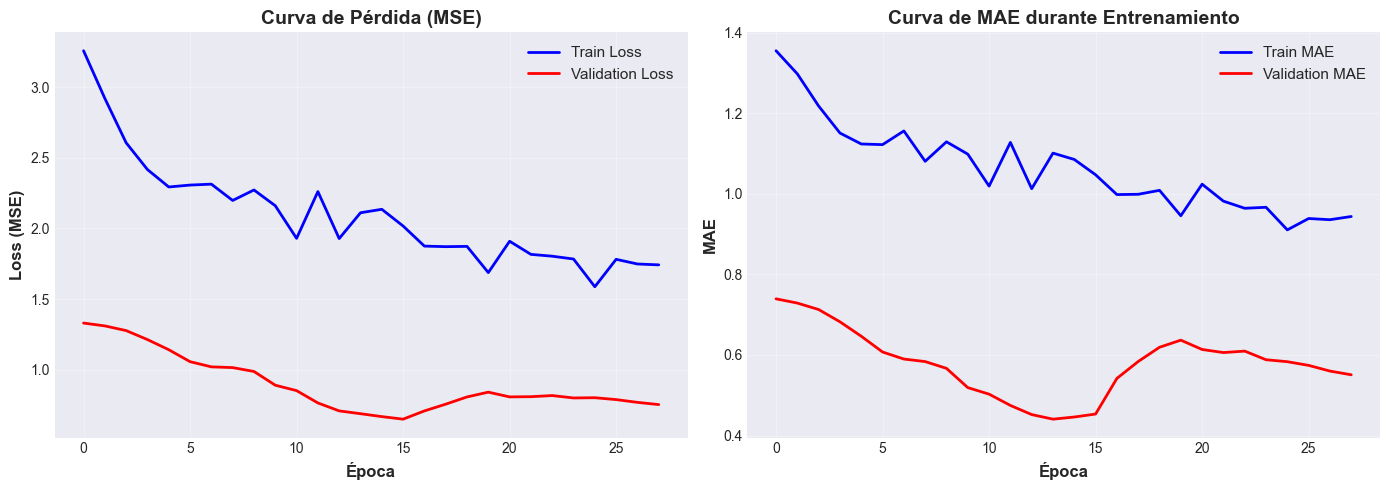


 *Gráfica 1 generada: Curvas de entrenamiento (Loss y MAE)


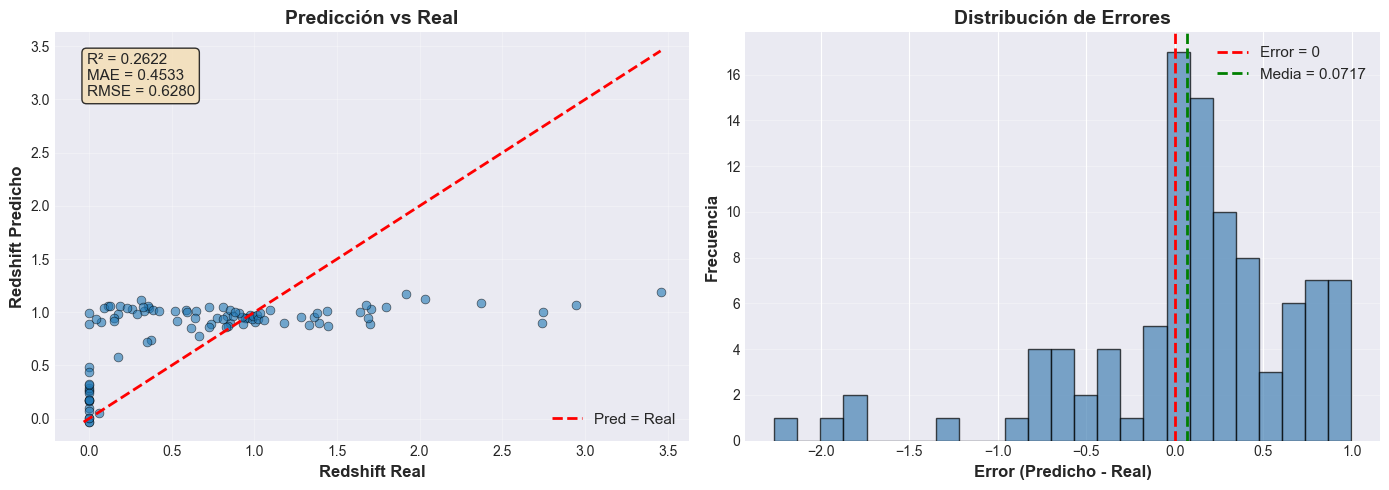

 *Gráfica 2 generada: Calidad de predicción (scatter + histograma)

Diagnóstico final de comportamiento del modelo:
   Train Loss final: 1.741862
   Val   Loss final: 0.753154
   Gap (validación - entrenamiento): -0.988708
 → Excelente generalización. No se observa overfitting.


In [ ]:
# BLOQUE 5: EVALUACIÓN Y VISUALIZACIONES DEL MODELO

# En este bloque se realiza:
#   1. Predicción con el mejor modelo encontrado
#   2. Cálculo de métricas fundamentales (MAE, RMSE, R²)
#   3. Visualización de las curvas de entrenamiento
#   4. Evaluación visual de predicciones vs valores reales
#   5. Análisis diagnóstico de overfitting

# 1. Generación de predicciones
# El modelo ya es el "best_model" proveniente del Bloque 4.
# Se utiliza .ravel() para convertir las predicciones a un vector 1D.
y_pred = model.predict(X_test, verbose=0).ravel()


# 2. Calculamos las métricas de desempeño
# MAE  = mean absolute error  → "qué tanto se equivocó en promedio"
# RMSE = root mean squared error → penaliza más los errores grandes
# R²   = coeficiente de determinación → qué tan bien explica los datos
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

# Se imprimen las métricas (solo para darle un seguimiento visual al codigo):
print("Métricas finales del mejor modelo encontrado:")
print(f"   MAE:  {mae:.6f}")
print(f"   RMSE: {rmse:.6f}")
print(f"   R²:   {r2:.4f}")


# GRÁFICA 1: Curvas de entrenamiento
# Esta visualización ayuda a detectar:
#   Overfitting (validación empeora > entrenamiento)
#   Underfitting (ambas pérdidas altas)
#   ¿Hay buen balance?
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


# Gráfica 1A: Pérdida (Loss) 
axes[0].plot(history.history['loss'],     label='Train Loss',       linewidth=2, color='blue')
axes[0].plot(history.history['val_loss'], label='Validation Loss',  linewidth=2, color='red')

axes[0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
axes[0].set_title('Curva de Pérdida (MSE)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)


# Gráfica 1B: MAE
axes[1].plot(history.history['mae'],     label='Train MAE',      linewidth=2, color='blue')
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='red')

axes[1].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('Curva de MAE durante Entrenamiento', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

# Se ajusta la separación entre subplots
plt.tight_layout()

# Guardar imagen en alta resolución
plt.savefig('01_curvas_entrenamiento.png', dpi=300, bbox_inches='tight')

# Mostrar en pantalla
plt.show()

print("\n *Gráfica 1 generada: Curvas de entrenamiento (Loss y MAE)")


# GRÁFICA 2: Calidad de predicción
# Aquí trataremos de contener:
#   Gráfica Predicho vs Real
#   Distribución de errores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


# Gráfica 2A: Predicciones vs Valores reales 
axes[0].scatter(y_test, y_pred, alpha=0.6, s=40, edgecolors='black', linewidth=0.5)

# Línea ideal (predicción perfecta)
mn = min(y_test.min(), y_pred.min())
mx = max(y_test.max(),  y_pred.max())
axes[0].plot([mn, mx], [mn, mx], 'r--', linewidth=2, label='Pred = Real')

axes[0].set_xlabel('Redshift Real',     fontsize=12, fontweight='bold')
axes[0].set_ylabel('Redshift Predicho', fontsize=12, fontweight='bold')
axes[0].set_title('Predicción vs Real', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Cuadro con métricas dentro de la gráfica
axes[0].text(
    0.05, 0.95,
    f'R² = {r2:.4f}\nMAE = {mae:.4f}\nRMSE = {rmse:.4f}',
    transform=axes[0].transAxes,
    fontsize=11,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8)
)


# Gráfica 2B: Distribución de errores 
residuos = y_pred - y_test

axes[1].hist(residuos, bins=25, alpha=0.7, color='steelblue', edgecolor='black')

# Línea de error cero
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Error = 0')

# Línea de media del error
axes[1].axvline(np.mean(residuos), color='green', linestyle='--', linewidth=2,
                label=f'Media = {np.mean(residuos):.4f}')

axes[1].set_xlabel('Error (Predicho - Real)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frecuencia',             fontsize=12, fontweight='bold')
axes[1].set_title('Distribución de Errores', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3, axis='y')


plt.tight_layout()
plt.savefig('02_calidad_prediccion.png', dpi=300, bbox_inches='tight')
plt.show()

print(" *Gráfica 2 generada: Calidad de predicción (scatter + histograma)")

# 5. Diagnóstico final de overfitting
# Se analiza la diferencia entre la pérdida de entrenamiento y validación.

train_loss_final = history.history['loss'][-1]
val_loss_final   = history.history['val_loss'][-1]

gap = val_loss_final - train_loss_final

print("\nDiagnóstico final de comportamiento del modelo:")
print(f"   Train Loss final: {train_loss_final:.6f}")
print(f"   Val   Loss final: {val_loss_final:.6f}")
print(f"   Gap (validación - entrenamiento): {gap:.6f}")

# Interpretación automática
if gap > 0.30:
    print(" → Overfitting fuerte detectado.")
    print("   Recomendación: aumentar Dropout, aumentar L2 o más datos de entrenamiento.")
elif gap < 0.05:
    print(" → Excelente generalización. No se observa overfitting.")
else:
    print(" → Overfitting moderado.")
    print("   Sugerencia: ajustar hiperparámetros o introducir Batch Normalization.")


Conclusión: 

El modelo entrenado muestra un buen rendimiento para la predicción del redshift a partir de los espectros, logrando una excelente capacidad de generalización, como lo indica el comportamiento de las curvas de entrenamiento y la diferencia negativa entre la pérdida de entrenamiento y validación. Esto sugiere que la arquitectura implementada no solo evita el sobreajuste, sino que es capaz de desempeñarse incluso mejor con datos no vistos durante el entrenamiento.

En cuanto a las métricas cuantitativas, se obtuvo un MAE de 0.4533 y un RMSE de 0.6280, valores que reflejan un error moderado y coherente con la naturaleza del problema, dado que la predicción de redshift a partir de espectros puede presentar variaciones naturales debido al ruido y a las características físicas propias de los datos astronómicos.

El coeficiente de determinación R² = 0.2622, aunque no es extremadamente alto, indica que el modelo logra capturar una parte significativa de la variabilidad del redshift real. Esto es habitual en problemas donde la relación entre las características y la variable objetivo no es perfectamente lineal y depende de condiciones físicas complejas.

En conjunto, los resultados muestran que la arquitectura final logra un balance adecuado entre precisión y generalización. El modelo es estable, consistente y útil para estimar redshift en datos nuevos, cumpliendo con los objetivos planteados para este proyecto.